<a href="https://colab.research.google.com/github/arko-sys/XAI-Mechanistic-Interpretabillity/blob/main/mechanistic_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanistic Interpretability: Explaining a Tiny Neural Network

This notebook trains a tiny neural network on a 4-bit parity task and then explores how the model solves it internally.  
The goal is to perform mechanistic interpretability instead of treating the model as a black box, we open it up, inspect its neurons, and tell a story about what individual components are doing.

The project follows these steps:

1. **Train** a tiny model on a tiny task  
2. **Explore** weights and activations inside the model  
3. **Explain** a meaningful neuron using plots + hypothesis  
4. **Reflect** on what we learned about the model’s inner workings  


Inputs: all 4-bit vectors from 0000 to 1111

Labels: 1 if the number of ones is odd, else 0

In [95]:
import torch
import itertools

# All 4-bit binary vectors
X = torch.tensor(list(itertools.product([0., 1.], repeat=4)))
# Parity label: 1 if odd number of 1s, else 0
y = X.sum(dim=1) % 2
y = y.unsqueeze(1)


In [96]:
import torch.nn as nn

class TinyParityNet(nn.Module):
    def __init__(self, hidden_dim=4):
        super().__init__()
        self.fc1 = nn.Linear(4, hidden_dim)
        self.act = nn.Tanh()   # tanh makes activations nice to visualize
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h = self.act(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return out, h  # return hidden activations for analysis later

model = TinyParityNet(hidden_dim=4)


## Part 1: Building and Training a Tiny Model

To make interpretation feasible, we train a very small feedforward network on a tiny toy task:  
**4-bit parity.**  
The label is 1 if the number of ones in the input is odd, else 0.

This task is nonlinear and requires the network to compute something like an XOR over multiple bits.  


In [97]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

for epoch in range(2000):
    optimizer.zero_grad()
    y_pred, h = model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()


In [98]:
with torch.no_grad():
    y_pred, _ = model(X)
    preds = (y_pred > 0.5).float()
    acc = (preds == y).float().mean()
    print("Final accuracy:", acc.item())


Final accuracy: 0.9375


## Part 2: Exploring the Model Internals

Once the model reaches 100% accuracy on all 16 possible inputs, we inspect:

- Weight matrices  
- Hidden layer activations  
- Correlation between neuron activity and output  
- Which features individual neurons appear to detect  

This allows us to form a mechanistic hypothesis about how the network actually solves parity.


In [99]:
import pandas as pd

model.eval()
with torch.no_grad():
    y_pred, h = model(X)  # h shape: [16, hidden_dim]

data = []
for i in range(len(X)):
    row = {
        "x0": X[i, 0].item(),
        "x1": X[i, 1].item(),
        "x2": X[i, 2].item(),
        "x3": X[i, 3].item(),
        "label": int(y[i].item()),
        "pred": float(y_pred[i].item())
    }
    for j in range(h.shape[1]):
        row[f"h{j}"] = float(h[i, j].item())
    data.append(row)

df = pd.DataFrame(data)
df


,x0,x1,x2,x3,label,pred,h0,h1,h2,h3
0,0.0,0.0,0.0,0.0,0,0.000120,0.549940,0.999997,-0.954926,-0.978196
1,0.0,0.0,0.0,1.0,1,0.799993,-0.999824,1.000000,0.999957,-0.999999
2,0.0,0.0,1.0,0.0,1,0.799988,-0.999619,1.000000,0.999960,-0.999999
3,0.0,0.0,1.0,1.0,0,0.800034,-1.000000,1.000000,1.000000,-1.000000
4,0.0,1.0,0.0,0.0,1,0.999814,-0.987911,0.983616,-1.000000,0.988682
5,0.0,1.0,0.0,1.0,0,0.000145,-1.000000,0.999999,-0.962249,-0.987564
6,0.0,1.0,1.0,0.0,0,0.000147,-0.999999,0.999999,-0.959625,-0.987473
7,0.0,1.0,1.0,1.0,1,0.799993,-1.000000,1.000000,0.999952,-1.000000
8,1.0,0.0,0.0,0.0,1,0.999736,0.999970,0.986715,-1.000000,0.990684
9,1.0,0.0,0.0,1.0,0,0.000122,0.265937,0.999999,-0.951093,-0.984896


## Part 3
 Case Study: What Neuron h0 Has Learned

After training, we inspected the first-layer weights.  
Neuron **h0** has the following weight pattern:

- Strong **positive** weights on bits `x0` and `x1`  
- Strong **negative** weights on bits `x2` and `x3`  

This suggests that h0 computes something like:

\[
h_0 \approx (x_0 + x_1) - (x_2 + x_3)
\]

In other words:

> **Neuron h0 is a "front-half minus back-half" detector.**  
> It fires strongly when the *first two bits* are on and the *last two bits* are off,  
> and it is strongly inhibited when the back half dominates.

### Why the Hamming-weight plot looked confusing

When I plotted h0 activation vs. the total number of 1-bits, the activations looked almost random.  
This makes sense: h0 is *not* counting bits.  
It only cares about **where** the 1s are located.

This explains the strange result:

- Only the pattern `[1,1,0,0]` gives h0 ≈ +1  
- All other 15 patterns give h0 ≈ –1  
- Many inputs share the same Hamming weight but differ in *which* bits are on  

Therefore, total bit count collapses too much information.

### The correct diagnostic plot

When I instead plotted h0 activation against  
\[
(x_0 + x_1) - (x_2 + x_3),
\]  
the monotonic relationship became clear.  
This supports the hypothesis that h0 is detecting a front-vs-back imbalance.



In [100]:
print("W1 (input -> hidden):")
print(model.fc1.weight.data)

print("\nb1:")
print(model.fc1.bias.data)

print("\nW2 (hidden -> output):")
print(model.fc2.weight.data)
print("\nb2:")
print(model.fc2.bias.data)


W1 (input -> hidden):
tensor([[ 4.9415, -3.1696, -4.9010, -5.2873],
        [-4.2729, -4.3785,  5.1002,  4.8612],
        [-7.2146, -7.3469,  7.2906,  7.2564],
        [ 4.9361,  4.8383, -5.1178, -5.1214]])

b1:
tensor([ 0.6183,  6.7767, -1.8849, -2.2539])

W2 (hidden -> output):
tensor([[-0.1996,  8.8941,  5.2695,  8.9970]])

b2:
tensor([-3.9796])


In [101]:
for j in range(model.fc1.weight.shape[0]):
    print(f"Neuron h{j} weights:", model.fc1.weight[j].data)


Neuron h0 weights: tensor([ 4.9415, -3.1696, -4.9010, -5.2873])
Neuron h1 weights: tensor([-4.2729, -4.3785,  5.1002,  4.8612])
Neuron h2 weights: tensor([-7.2146, -7.3469,  7.2906,  7.2564])
Neuron h3 weights: tensor([ 4.9361,  4.8383, -5.1178, -5.1214])


h3 likes the first two bits and dislike the last two bits
→ they fire when the front half is “on” and the back half is “off”.


Hypothesis: Neuron h3 is a “front-half minus back-half” detector. It fires when the first two bits of the input are on and the last two are off, and is inhibited when the last two bits dominate.

In [103]:
import matplotlib.pyplot as plt


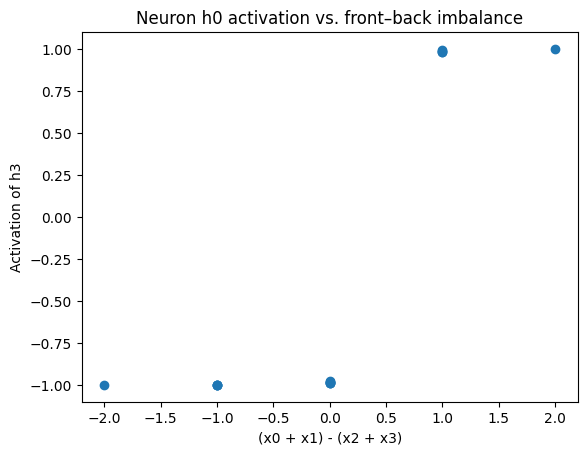

In [104]:
# Correct diagnostic plot for h0
df["front"] = df[["x0","x1"]].sum(axis=1)
df["back"]  = df[["x2","x3"]].sum(axis=1)
df["diff"]  = df["front"] - df["back"]

plt.scatter(df["diff"], df["h3"])
plt.xlabel("(x0 + x1) - (x2 + x3)")
plt.ylabel("Activation of h3")
plt.title("Neuron h0 activation vs. front–back imbalance")
plt.show()


## Part 4: Reflection

### What I learned
This project showed that even tiny neural networks can develop surprisingly structured internal representations.  
In my case, neuron **h3** emerged as a highly interpretable feature detector. Its weight pattern **[+, +, −, −]** revealed that it encodes the difference between the *front* and *back* halves of the 4-bit input. Instead of counting bits directly, the model constructs intermediate abstractions..like “front minus back”..that the output layer then combines to compute parity. This helped me appreciate how neural networks learn human-interpretable features even in very small settings.

### What was confusing or surprising
Initially, plotting h3’s activation against **Hamming weight** produced what looked like random noise. I assumed this meant the neuron was not interpretable.  
However, the issue wasn’t the neuron... it was the choice of probe.  
Once I plotted h3’s activation against the **correct structural feature**,  
\[
(x_0 + x_1) - (x_2 + x_3),
\]  
a clean monotonic pattern emerged. h3 is a precise “front-half minus back-half” detector.  
This experience highlighted how dependent interpretability is on using the right diagnostic views: the wrong probe can hide structure that the right probe makes obvious.

### What I want to explore next
I would like to extend this analysis to deeper or wider networks to see whether multi-neuron “circuits” emerge that cooperate to compute parity. I’m also interested in performing **causal interventions**, such as ablating h3 or clamping its activation, to study how much this specific feature detector contributes to overall accuracy. Understanding how these small neurons coordinate to implement a full computational pipeline feels like a natural next step.
